In [1]:
import logging

import numpy as np
import probtorch
import torch

import bouncing_ball
import bouncing_ball_data
import combinators
import smc
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 50 ## sequence length
num_series = 20
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

/home/work/AnacondaProjects/combinators/bouncing_ball_data.py:80: RuntimeWarning: invalid value encountered in true_divide
  A = A / A.sum(1)[:, None]


In [6]:
num_particles = 500

In [7]:
bouncing_ball_step = combinators.Model(bouncing_ball.bouncing_ball_step, {}, {
    'delta_t': torch.ones(1),
})

In [8]:
smc_runner = smc.SequentialMonteCarlo(bouncing_ball_step, T)

In [9]:
init_bouncing_ball_params = {
    'position_0': {
        'loc': torch.rand(2) * Boundary,
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.Tensor([0.40, 0.20, 0.20, 0.20]),
    },
    'alpha_2': {
        'concentration': torch.Tensor([0.20, 0.40, 0.20, 0.20]),
    },
    'alpha_3': {
        'concentration': torch.Tensor([0.20, 0.20, 0.40, 0.20]),
    },
    'alpha_4': {
        'concentration': torch.Tensor([0.20, 0.20, 0.20, 0.40]),
    },
    'directions': {
        'loc': {
            'loc': torch.Tensor([[1, 1], [-1, 1], [1, -1], [-1, -1]]) * (1/np.sqrt(2)),
            'scale': torch.ones(4, 2) * 0.1,
        },
        'scale': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2) * 0.1,
        },
    },
}

In [10]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['displacement_%d' % i] = displacements[i-1]
    
    return trajectory, displacements, data

In [11]:
def accumulate_trajectory(inference):
    result = torch.zeros(num_particles, len(trajectory), 2)
    result[:, 0] = inference['position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['displacement_%d' % (t+1)].value
    return result

In [12]:
def graph_position_trajectory(positions, T, s):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    plt.savefig('position_trajectory_%d.pdf' % s)

In [13]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [14]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

07/31/2018 15:55:28 Variational SMC ELBO=-1.06124487e+03 at epoch 1
07/31/2018 15:55:33 Variational SMC ELBO=-1.24189355e+03 at epoch 2
07/31/2018 15:55:38 Variational SMC ELBO=-1.18220154e+03 at epoch 3
07/31/2018 15:55:44 Variational SMC ELBO=-1.13873328e+03 at epoch 4
07/31/2018 15:55:50 Variational SMC ELBO=-1.09995581e+03 at epoch 5
07/31/2018 15:55:56 Variational SMC ELBO=-1.16216528e+03 at epoch 1
07/31/2018 15:56:01 Variational SMC ELBO=-1.11611340e+03 at epoch 2
07/31/2018 15:56:08 Variational SMC ELBO=-1.17545032e+03 at epoch 3
07/31/2018 15:56:14 Variational SMC ELBO=-1.16210144e+03 at epoch 4
07/31/2018 15:56:20 Variational SMC ELBO=-1.17851111e+03 at epoch 5
07/31/2018 15:56:27 Variational SMC ELBO=-1.20006140e+03 at epoch 1
07/31/2018 15:56:32 Variational SMC ELBO=-1.14860205e+03 at epoch 2
07/31/2018 15:56:39 Variational SMC ELBO=-1.17232129e+03 at epoch 3
07/31/2018 15:56:46 Variational SMC ELBO=-1.23687878e+03 at epoch 4
07/31/2018 15:56:52 Variational SMC ELBO=-1.1979

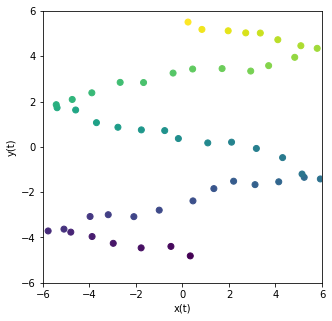

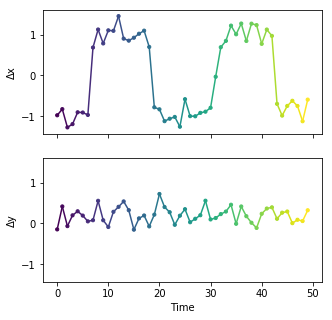

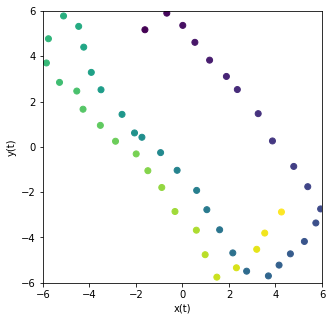

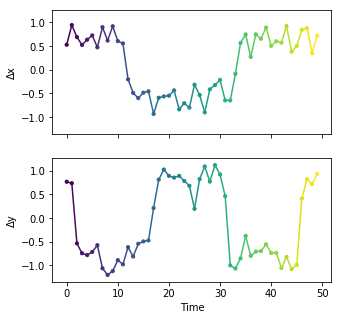

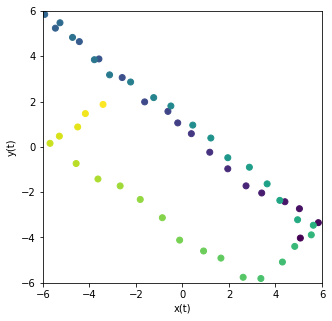

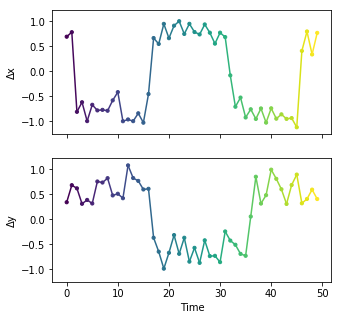

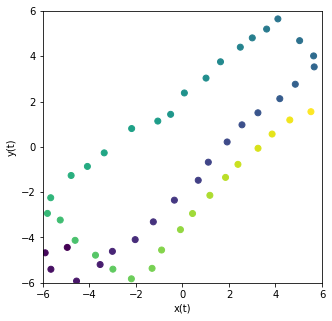

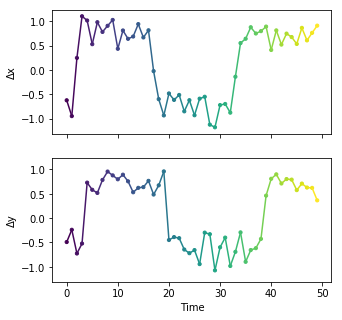

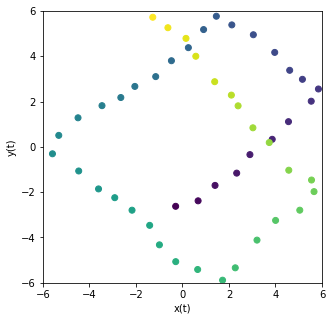

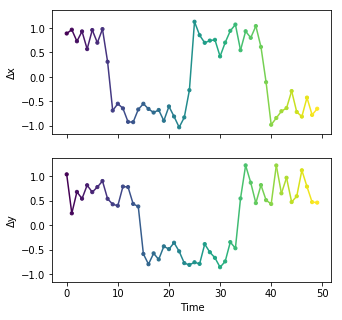

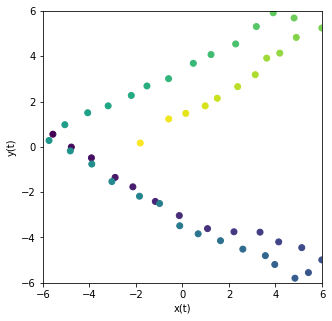

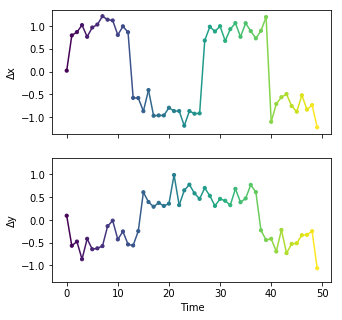

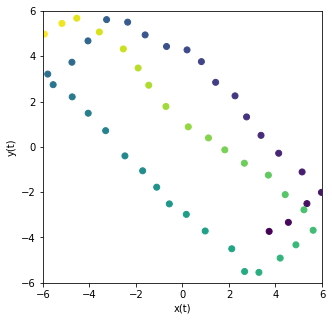

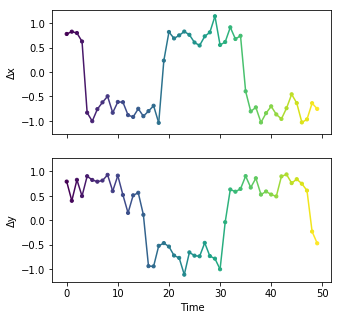

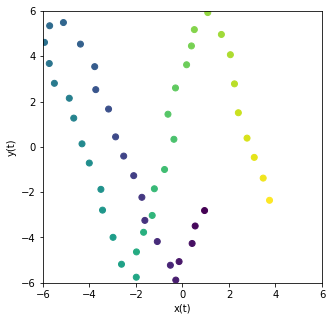

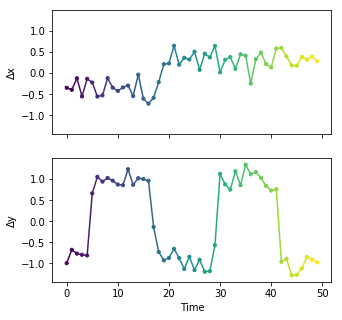

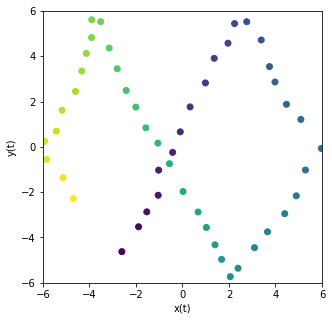

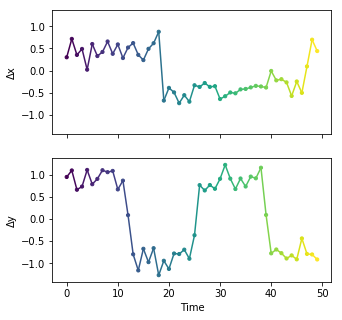

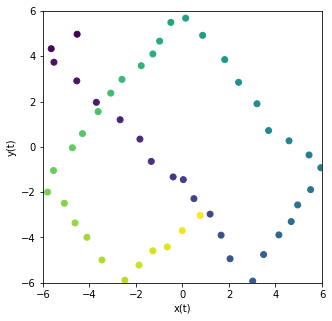

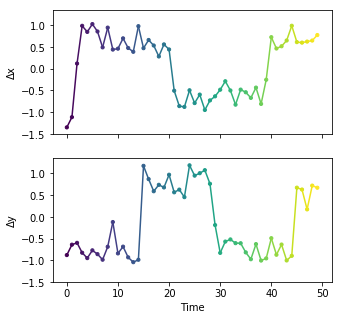

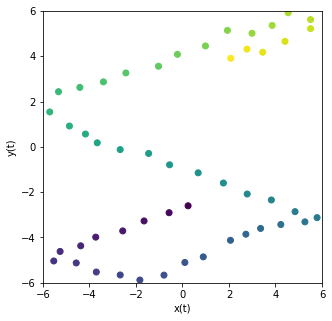

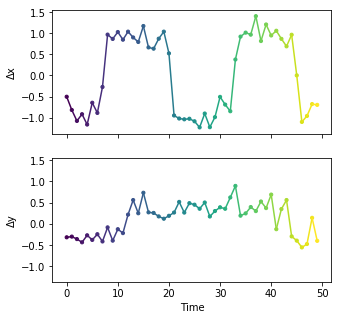

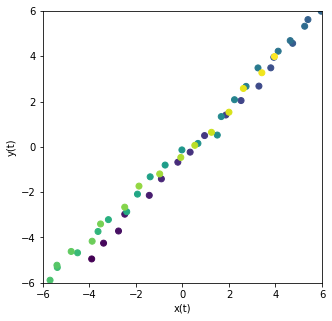

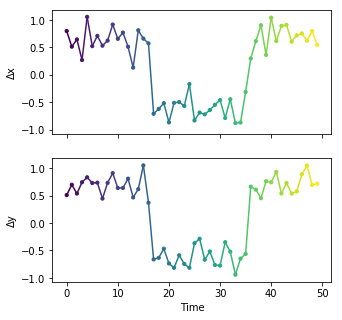

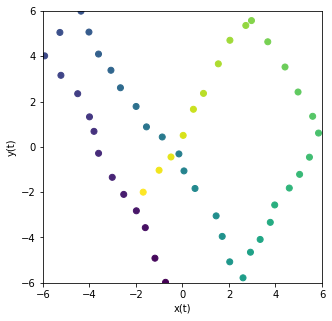

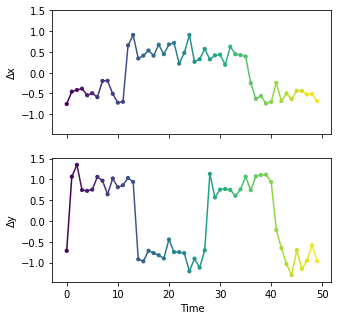

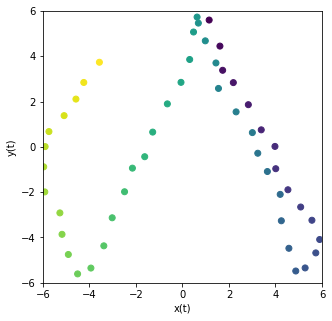

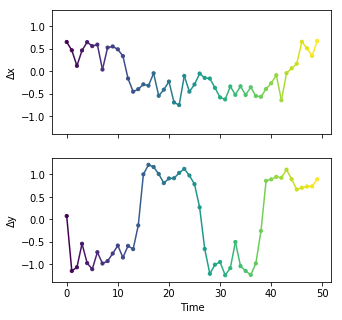

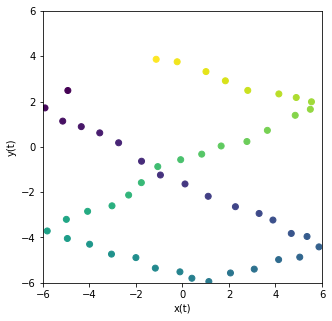

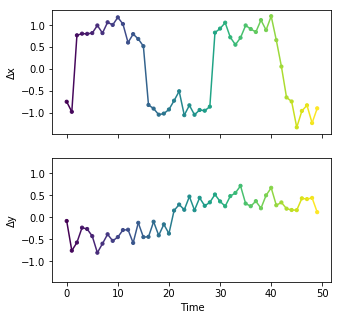

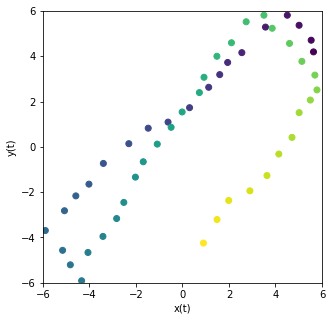

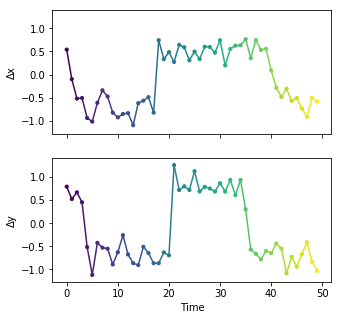

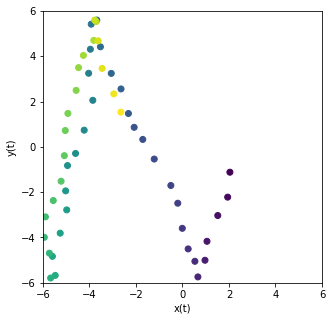

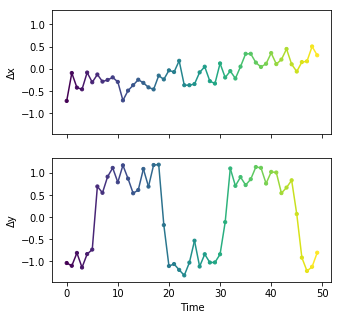

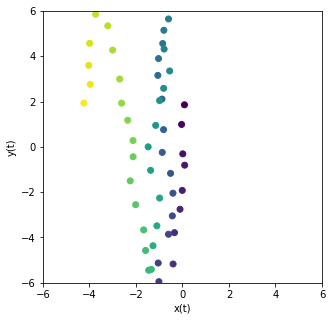

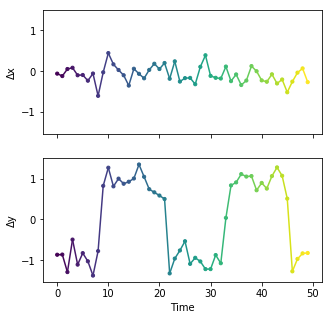

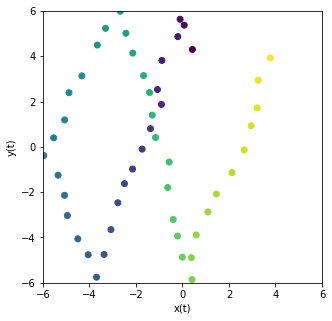

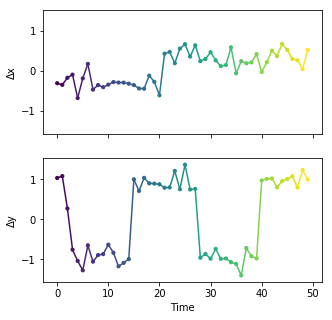

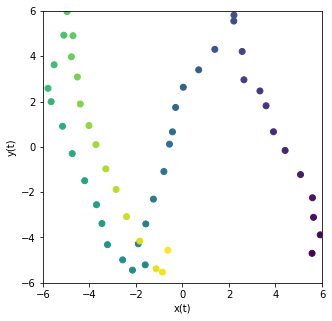

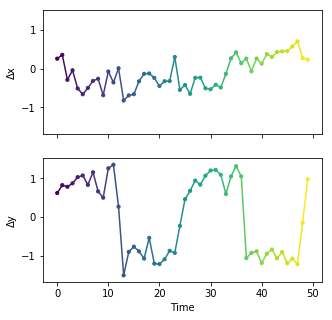

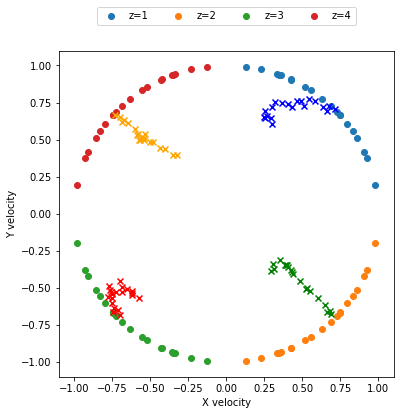

In [15]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)
    init_bouncing_ball = combinators.Model(bouncing_ball.init_bouncing_ball,
                                           init_bouncing_ball_params, {})
    inference, init_bouncing_ball_params = smc.variational_smc(
        num_particles, init_bouncing_ball, smc_runner, 5, data,
        use_cuda=False, lr=1e-2
    )
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = torch.stack([inferred_trajectory[:, t+1] for t in range(T)], dim=1).mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['displacement_%d' % (t+1)].value for t in range(T)], dim=1).mean(dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_position_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    modal_directions[s] = init_bouncing_ball_params['directions']['loc']['loc']
    
    plt.close('all')

graph_velocity_frequencies(modal_directions.detach().numpy())